# Import Modules

In [197]:
import time
from os import listdir
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [198]:
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint

# Reading Data

In [199]:
classes_dir = sorted(listdir("data/Kather_texture_2016_image_tiles_5000"))
classes_dir.remove('.DS_Store')
classes_dir

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [200]:
# for c in classes_dir:
# 	files = listdir(f'data/Kather_texture_2016_image_tiles_5000/{c}')
# 	for f in files:
# 		print(f'{c}: {f}')

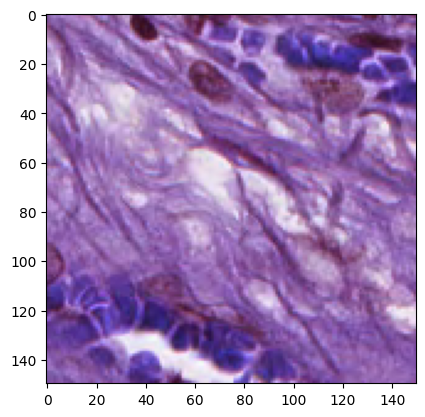

In [201]:
img = cv2.imread('data/Kather_texture_2016_image_tiles_5000/01_TUMOR/89F4_CRC-Prim-HE-09_022.tif_Row_1_Col_1.tif')
plt.imshow(img)

In [202]:
# tf.debugging.set_log_device_placement(True)

when splitting the variable name into '01' and 'tumor', than when doing the hotencoding, the tumor will not be class 0. Because the hotencoding will sort the value alphabetically. Therefore it is easier to pass the variable name as "01_tumor", so will the hot encoding have class 0 as tumor.

bilder 150x150.
und dann nochmals 50x50
inkl zeitmessen

In [203]:
with tf.device('/CPU:0'): # running on CPU
	start = datetime.now()
	data = []
	labels_string = []
	path = 'data/Kather_texture_2016_image_tiles_5000'
	for c in classes_dir:
		files = listdir(f'{path}/{c}')
		for f in files:
			# l = c.split('_')[1].lower() # to pass only name of class without numbering.
			labels_string.append(c)
			img = load_img(f'{path}/{c}/{f}', target_size=(128, 128))
			img = img_to_array(img)
			# img = preprocess_input(img)
			img = tf.cast(img, tf.float32) / 255.0
			data.append(img)
	end = datetime.now()

	data = np.array(data, dtype='float32')
	labels_string = np.array(labels_string)
	print(end-start)


0:00:03.374737


In [204]:
data[3][0][0]

array([0.36862746, 0.14509805, 0.3529412 ], dtype=float32)

In [205]:
labels_string

array(['01_TUMOR', '01_TUMOR', '01_TUMOR', ..., '08_EMPTY', '08_EMPTY',
       '08_EMPTY'], dtype='<U10')

In [206]:
data.shape

(5000, 128, 128, 3)

In [207]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_string)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[1 0 0 0 0 0 0 0] 1 <class 'numpy.ndarray'>


Checking for classes

In [208]:
lb.classes_

array(['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS',
       '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'], dtype='<U10')

## Train-split data

In [209]:
# Split into train, val, test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8, random_state=13)
# x_train, x_val, y_train, y_val = train_test_split(y_train, y_test, test_size = 0.5,train_size =0.75)

In [210]:
# Split into train, val, test set
x, x_test, y, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [211]:
len(x_test)

1000

In [212]:
len(x_train)

3000

In [213]:
len(x_val)

1000

In [214]:
len(y_test)

1000

In [215]:
print(lb.inverse_transform( y_test[0:5] ))
print('--------')
print(y_test)

['01_TUMOR' '04_LYMPHO' '04_LYMPHO' '02_STROMA' '07_ADIPOSE']
--------
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]]


In [216]:
print(lb.inverse_transform(y_test))

['01_TUMOR' '04_LYMPHO' '04_LYMPHO' '02_STROMA' '07_ADIPOSE' '08_EMPTY'
 '05_DEBRIS' '01_TUMOR' '02_STROMA' '02_STROMA' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '03_COMPLEX' '03_COMPLEX' '08_EMPTY' '01_TUMOR' '06_MUCOSA'
 '06_MUCOSA' '04_LYMPHO' '02_STROMA' '05_DEBRIS' '03_COMPLEX' '07_ADIPOSE'
 '05_DEBRIS' '04_LYMPHO' '06_MUCOSA' '04_LYMPHO' '01_TUMOR' '07_ADIPOSE'
 '07_ADIPOSE' '07_ADIPOSE' '04_LYMPHO' '01_TUMOR' '08_EMPTY' '03_COMPLEX'
 '02_STROMA' '03_COMPLEX' '08_EMPTY' '07_ADIPOSE' '02_STROMA' '03_COMPLEX'
 '03_COMPLEX' '07_ADIPOSE' '08_EMPTY' '03_COMPLEX' '08_EMPTY' '03_COMPLEX'
 '04_LYMPHO' '05_DEBRIS' '08_EMPTY' '06_MUCOSA' '03_COMPLEX' '07_ADIPOSE'
 '01_TUMOR' '06_MUCOSA' '02_STROMA' '06_MUCOSA' '08_EMPTY' '02_STROMA'
 '03_COMPLEX' '01_TUMOR' '01_TUMOR' '08_EMPTY' '05_DEBRIS' '04_LYMPHO'
 '07_ADIPOSE' '05_DEBRIS' '04_LYMPHO' '04_LYMPHO' '08_EMPTY' '08_EMPTY'
 '08_EMPTY' '08_EMPTY' '08_EMPTY' '03_COMPLEX' '08_EMPTY' '06_MUCOSA'
 '06_MUCOSA' '05_DEBRIS' '02_STROMA' '08_EMPTY' '07_

## Data augmentation

In [217]:
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(15,7))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        # ax.imshow((img * 255).astype(np.uint8))

    plt.tight_layout()
    plt.show()

In [218]:
image_gen = ImageDataGenerator(#rescale=1/255,
							   horizontal_flip=True,
							   rotation_range=45,
							   zoom_range = 0.5,
							   width_shift_range=0.2,
							   height_shift_range=0.2,
							   shear_range=0.2,
							   fill_mode='nearest')
#
# train_data_gen = image_gen.flow_from_directory(batch_size=128,
#                                                directory=base_dir,
#                                                shuffle=True,
#                                                target_size=(150,150))
train_data_gen = image_gen.flow(x_train, y_train,
									batch_size=32, #128
								   # directory=base_dir,
								   shuffle=False,
								   )

val_data_gen = image_gen.flow(x_val, y_val,
									batch_size=32,
								   # directory=base_dir,
								   shuffle=False,
								   )

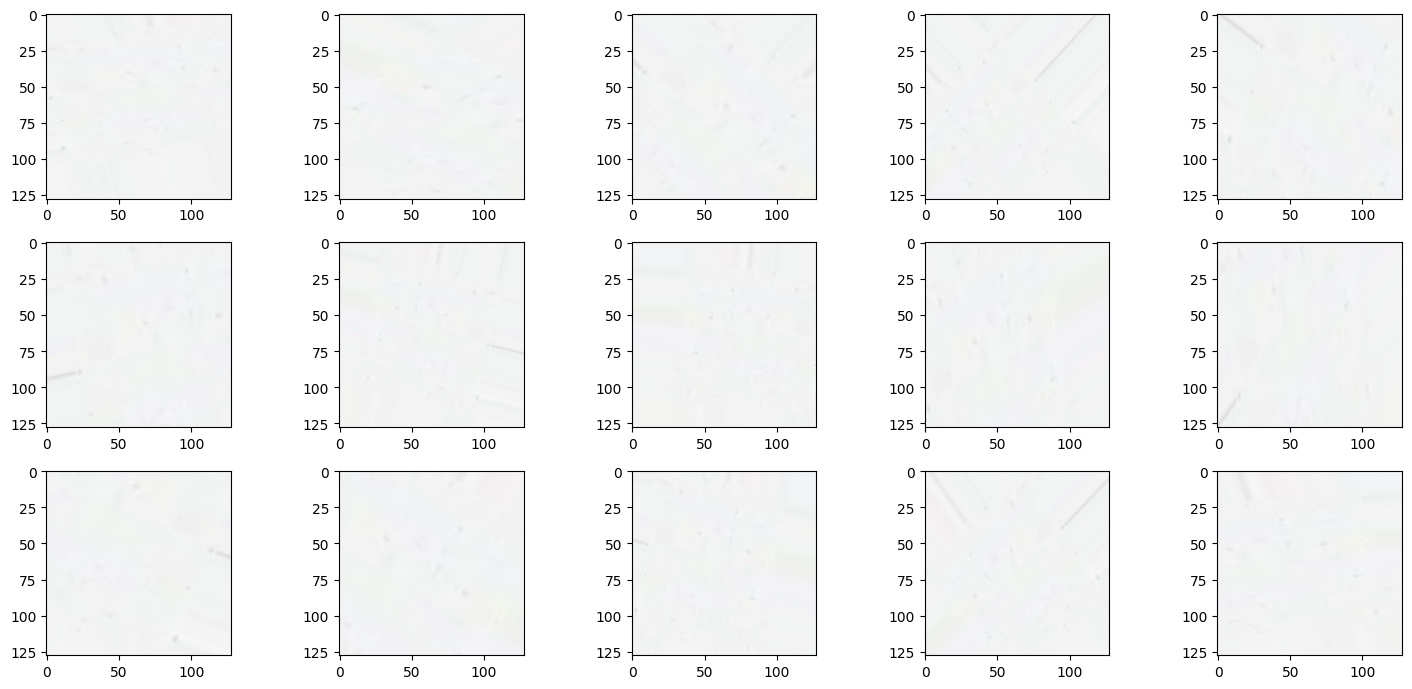

In [219]:
augmented_images = [train_data_gen[0][0][0] for i in range(15)]
plotImages(augmented_images)

## Model

In [220]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(156, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [221]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

In [222]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [223]:
EPOCHS = 150

In [224]:
filepath = 'model_gcm3.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [242]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=15)

In [243]:
import time


In [244]:

start = time.time()
history = model.fit(train_data_gen, batch_size = 32, epochs=EPOCHS, validation_data=val_data_gen,  callbacks=[checkpoint, earlystop_callback])
end = time.time()
delta = end-start
delta

Epoch 1/150
94/94 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9037
Epoch 1: val_accuracy did not improve from 0.85800
94/94 [==============================] - 7s 75ms/step - loss: 0.2486 - accuracy: 0.9037 - val_loss: 0.4978 - val_accuracy: 0.8350
Epoch 2/150
93/94 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8949
Epoch 2: val_accuracy did not improve from 0.85800
94/94 [==============================] - 7s 73ms/step - loss: 0.2813 - accuracy: 0.8950 - val_loss: 0.4445 - val_accuracy: 0.8430
Epoch 3/150
94/94 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8937
Epoch 3: val_accuracy did not improve from 0.85800
94/94 [==============================] - 7s 73ms/step - loss: 0.2719 - accuracy: 0.8937 - val_loss: 0.4300 - val_accuracy: 0.8510
Epoch 4/150
94/94 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8963
Epoch 4: val_accuracy did not improve from 0.85800
94/94 [===================

423.57048511505127

In [43]:
#history = model.fit(datagen.flow(x_train, y_train), batch_size = 32, epochs=EPOCHS, validation_data=datagen.flow(x_test, y_test))

In [238]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 13ms/step - loss: 0.4287 - accuracy: 0.8590


[0.42865586280822754, 0.859000027179718]

In [239]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

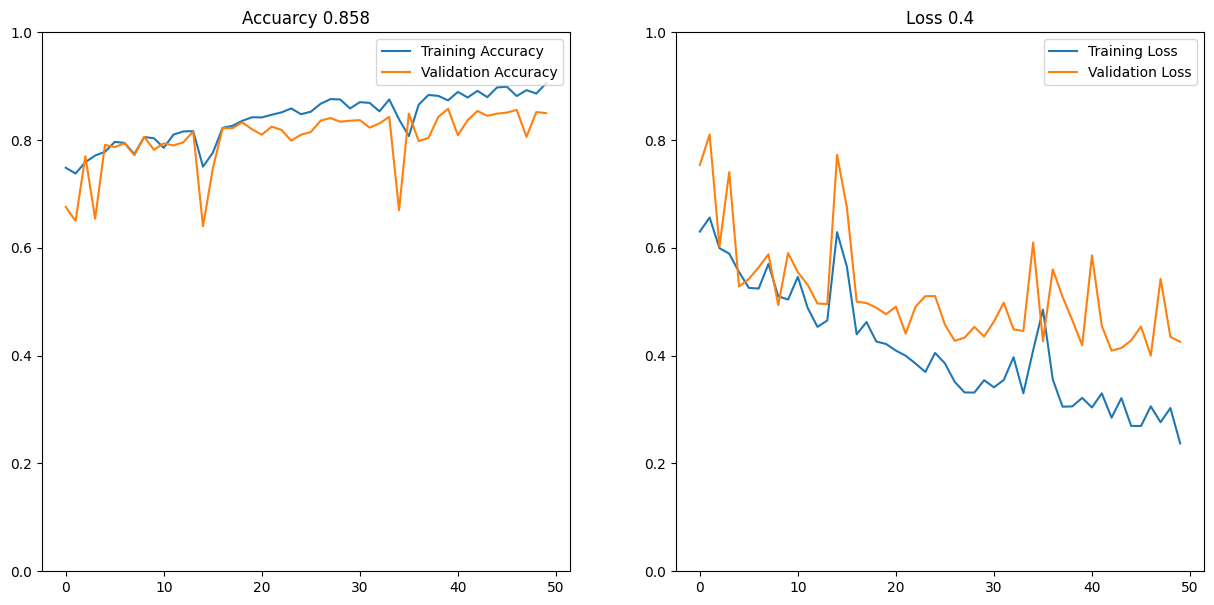

In [241]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title(f'Accuarcy {round(max(val_acc),3)}')
ax1.legend(loc='upper right')
ax1.set_ylim((0,1))

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title(f'Loss {round(min(val_loss),3)}')
ax2.legend(loc='upper right')
ax2.set_ylim((0,1))
plt.show()

In [68]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=32, verbose=0)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predIdxs, # labels transformed back to single unit
    target_names=lb.classes_))
# model.save("model_cancer_detection_cnn_v1_large", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

    01_TUMOR       0.95      0.96      0.96       104
   02_STROMA       0.94      0.79      0.86       150
  03_COMPLEX       0.77      0.77      0.77       116
   04_LYMPHO       0.85      0.95      0.90       119
   05_DEBRIS       0.86      0.91      0.89       119
   06_MUCOSA       0.92      0.95      0.93       125
  07_ADIPOSE       0.99      0.94      0.96       131
    08_EMPTY       0.96      0.99      0.97       136

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [49]:
predIdxs.shape

(1000,)

In [67]:
print(lb.classes_)

['01_TUMOR' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '08_EMPTY']


## loading model from saved models

In [44]:
model = tf.keras.models.load_model('model_gcm3.h5')

In [45]:
loss, acc = model.evaluate(x_val, y_val)

 5/32 [===>..........................] - ETA: 0s - loss: 0.3064 - accuracy: 0.8875

2023-03-27 19:20:17.061447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step - loss: 0.2917 - accuracy: 0.9160


In [46]:
print(f'loss: {loss}, acc: {acc}')

loss: 0.2917412519454956, acc: 0.9160000681877136


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        3

In [156]:
classes_dict = {
	0: 'Tumor',
	1: 'Stroma',
	2: 'Complex',
	3: 'Lympho',
	4: 'Debris',
	5: 'Mucosa',
	6: 'Adipose',
	7: 'Empty',
}

In [195]:
x_val.shape

(1000, 128, 128, 3)

In [194]:
prediction = model.predict(x_val)

32/32 [==============================] - 0s 12ms/step


In [159]:
labels = lb.inverse_transform(y_val)

Text(0.5, 1.0, 'True: Stroma, Predicted: Debris')

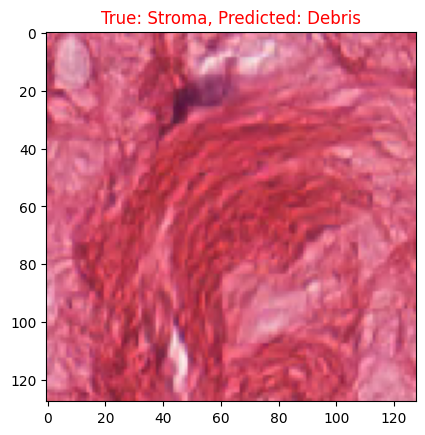

In [188]:
img_nr = 10
if labels[img_nr].split("_")[1].capitalize() == classes_dict[np.argmax(prediction[img_nr])]:
	color = 'green'
else:
	color = 'red'
fig, ax = plt.subplots()
plt.imshow(x_val[img_nr])
ax.set_title(f'True: {labels[img_nr].split("_")[1].capitalize()}, Predicted: {classes_dict[np.argmax(prediction[img_nr])]}', color=color)

In [139]:
x_val.shape

(1000, 128, 128, 3)

32/32 [==============================] - 0s 10ms/step


In [146]:
np.argmax(prediction[img_nr])

0

In [137]:
test_img.shape

(128, 128, 3)

In [145]:
lb.classes_

array(['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS',
       '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'], dtype='<U10')

In [151]:
classes_dict[np.argmax(prediction[img_nr])]

'Tumor'

In [185]:
correct = 0
wrong = 0
for i in range(len(labels)):
	print(i)
	if labels[i].split("_")[1].capitalize() == classes_dict[np.argmax(prediction[i])]:
		correct = correct + 1
	else:
		wrong = wrong + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [186]:
correct

892

In [187]:
wrong

108